## Author:Sivasubramanian Recently, I was reading through [A/B Testing with Machine Learning - A Step-by-Step Tutorial](https://www.business-science.io/business/2019/03/11/ab-testing-machine-learning.html) written by [Matt Dancho](https://www.linkedin.com/in/mattdancho/) of [Business Science](https://www.business-science.io). I have been always fascinated by the idea of **A/B Testing** and the amount of impact it can bring in businesses. The tutorial is very definitive and Matt has explained each and every step in the tutorial. He has detailed about each and every decision taken while developing the solution. 

Even though the tutorial is written in `R`, I was able to scram through his code and my knowledge of Data Science helped me to understand the concepts very quickly. I will have to thank Matt for putting together all the key ingredients of the Data Science world and or using them to solve a real problem.  

I decided to replicate the solution in `Python` and I was able to do it. However, there are some minor differences in my implementation but those can be ignored, I think. Apart from cell annotations, I have not detailed any of the steps because, for that, you really should follow the article I mentioned. 

## Data loading

In [1]:
import pandas as pd

control_data = pd.read_csv('data/control_data.csv')
experiment_data = pd.read_csv('data/experiment_data.csv')

In [2]:
control_data.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [3]:
experiment_data.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


## Number summaries and basic investigations

In [4]:
control_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


In [5]:
experiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


In [6]:
control_data.isna().sum()

Date            0
Pageviews       0
Clicks          0
Enrollments    14
Payments       14
dtype: int64

In [7]:
experiment_data.isna().sum()

Date            0
Pageviews       0
Clicks          0
Enrollments    14
Payments       14
dtype: int64

In [8]:
control_data[control_data['Enrollments'].isna()]

,Date,Pageviews,Clicks,Enrollments,Payments
23,"Mon, Nov 3",9437,788,NaN,NaN
24,"Tue, Nov 4",9420,781,NaN,NaN
25,"Wed, Nov 5",9570,805,NaN,NaN
26,"Thu, Nov 6",9921,830,NaN,NaN
27,"Fri, Nov 7",9424,781,NaN,NaN
28,"Sat, Nov 8",9010,756,NaN,NaN
29,"Sun, Nov 9",9656,825,NaN,NaN
30,"Mon, Nov 10",10419,874,NaN,NaN
31,"Tue, Nov 11",9880,830,NaN,NaN
32,"Wed, Nov 12",10134,801,NaN,NaN


In [9]:
experiment_data[experiment_data['Enrollments'].isna()]

,Date,Pageviews,Clicks,Enrollments,Payments
23,"Mon, Nov 3",9359,789,NaN,NaN
24,"Tue, Nov 4",9427,743,NaN,NaN
25,"Wed, Nov 5",9633,808,NaN,NaN
26,"Thu, Nov 6",9842,831,NaN,NaN
27,"Fri, Nov 7",9272,767,NaN,NaN
28,"Sat, Nov 8",8969,760,NaN,NaN
29,"Sun, Nov 9",9697,850,NaN,NaN
30,"Mon, Nov 10",10445,851,NaN,NaN
31,"Tue, Nov 11",9931,831,NaN,NaN
32,"Wed, Nov 12",10042,802,NaN,NaN


## Data wrangling

In [10]:
# Combine with Experiment data
data_total = pd.concat([control_data, experiment_data])
data_total.sample(10)

,Date,Pageviews,Clicks,Enrollments,Payments
6,"Fri, Oct 17",9008,748,146.0,76.0
31,"Tue, Nov 11",9931,831,NaN,NaN
20,"Fri, Oct 31",8890,706,174.0,101.0
35,"Sat, Nov 15",8630,743,NaN,NaN
2,"Mon, Oct 13",10511,909,167.0,95.0
22,"Sun, Nov 2",8836,724,182.0,103.0
16,"Mon, Oct 27",9655,771,213.0,119.0
8,"Sun, Oct 19",8459,691,131.0,60.0
18,"Wed, Oct 29",9262,727,201.0,96.0
32,"Wed, Nov 12",10134,801,NaN,NaN


In [11]:
import numpy as np
np.random.seed(7)
import sklearn.utils

# Add row id
data_total['row_id'] = data_total.index

# Create a Day of Week feature
data_total['DOW'] = data_total['Date'].str.slice(start=0, stop=3)

# Remove missing data
data_total.dropna(inplace=True)

# Add a binary column Experiment to denote
# if the data was part of the experiment or not (Random)
data_total['Experiment'] = np.random.randint(2, size=len(data_total))

# Remove missing data
data_total.dropna(inplace=True)

# Remove Date and Payments columns
del data_total['Date'], data_total['Payments']

# Shuffle the data
data_total = sklearn.utils.shuffle(data_total)

In [12]:
# Check the new data
data_total.head()

,Pageviews,Clicks,Enrollments,row_id,DOW,Experiment
21,8460,681,156.0,21,Sat,0
3,9867,827,138.0,3,Tue,1
21,8448,695,142.0,21,Sat,0
13,9434,673,220.0,13,Fri,1
6,9008,748,146.0,6,Fri,1


In [13]:
# Reorder the columns 
data_total = data_total[['row_id', 'Experiment', 'Pageviews', 'Clicks', 'DOW', 'Enrollments']]

In [14]:
data_total.head()

,row_id,Experiment,Pageviews,Clicks,DOW,Enrollments
21,21,0,8460,681,Sat,156.0
3,3,1,9867,827,Tue,138.0
21,21,0,8448,695,Sat,142.0
13,13,1,9434,673,Fri,220.0
6,6,1,9008,748,Fri,146.0


In [15]:
# Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_total.loc[:, data_total.columns != 'Enrollments'],\
                                                    data_total['Enrollments'], test_size=0.2)

In [16]:
# Converting strings to numbers
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
X_train['DOW'] = lb.fit_transform(X_train['DOW'])
X_test['DOW'] = lb.transform(X_test['DOW'])

In [17]:
X_train.head()

,row_id,Experiment,Pageviews,Clicks,DOW
16,16,0,9535,759,1
10,10,1,10551,864,5
2,2,0,10480,884,1
3,3,1,9867,827,5
16,16,0,9655,771,1


In [18]:
X_test.head()

,row_id,Experiment,Pageviews,Clicks,DOW
12,12,0,8324,665,4
18,18,1,9262,727,6
1,1,0,9288,785,3
1,1,0,9102,779,3
19,19,0,9345,734,4


## Helper functions
- Function for printing the evaluation scores related to a _regression_ problem
- Function for plotting the original values and values predicted by the model

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Oberservation')
    plt.ylabel('Enrollments')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

## Linear regression: A baseline

In [21]:
import statsmodels.api as sm

X_train_refined = X_train.drop(columns=['row_id'], axis=1)
linear_regression = sm.OLS(y_train, X_train_refined)
linear_regression = linear_regression.fit()

In [22]:
X_test_refined = X_test.drop(columns=['row_id'], axis=1)
y_preds = linear_regression.predict(X_test_refined)

In [23]:
calculate_metrics(y_test, y_preds)

RMSE Score: 23.988871314039862
R2_Squared: 0.050950018270392916
MAE Score: 19.586061838775095


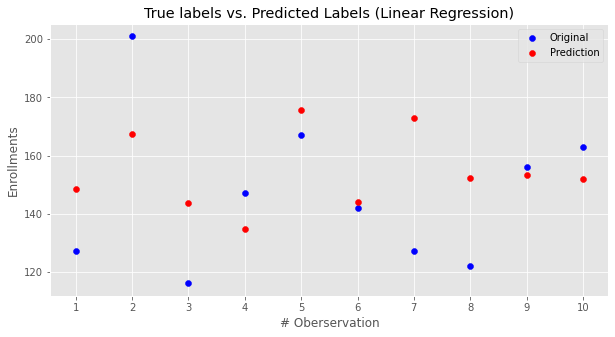

In [24]:
plot_preds(y_test, y_preds, 'Linear Regression')

In [25]:
print(linear_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:            Enrollments   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              400.1
Date:                Wed, 16 Feb 2022   Prob (F-statistic):                    7.92e-27
Time:                        22:18:28   Log-Likelihood:                         -163.65
No. Observations:                  36   AIC:                                      335.3
Df Residuals:                      32   BIC:                                      341.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [26]:
pd.DataFrame(linear_regression.pvalues)\
    .reset_index()\
    .rename(columns={'index':'Terms', 0:'p_value'})\
    .sort_values('p_value')

,Terms,p_value
1,Pageviews,1.974764e-07
2,Clicks,3.804647e-05
3,DOW,2.299762e-01
0,Experiment,8.634578e-01


## Model 02: Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf =4, random_state=7)
dtree.fit(X_train_refined, y_train)
y_preds = dtree.predict(X_test_refined)

calculate_metrics(y_test, y_preds)

RMSE Score: 26.8540034259326
R2_Squared: -0.1892893660531696
MAE Score: 21.78333333333333


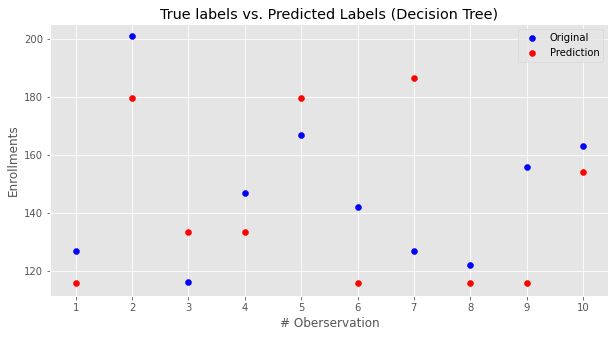

In [28]:
plot_preds(y_test, y_preds, 'Decision Tree')

## Decision tree visualization

In [29]:
#!pip install --upgrade scikit-learn==0.20.3

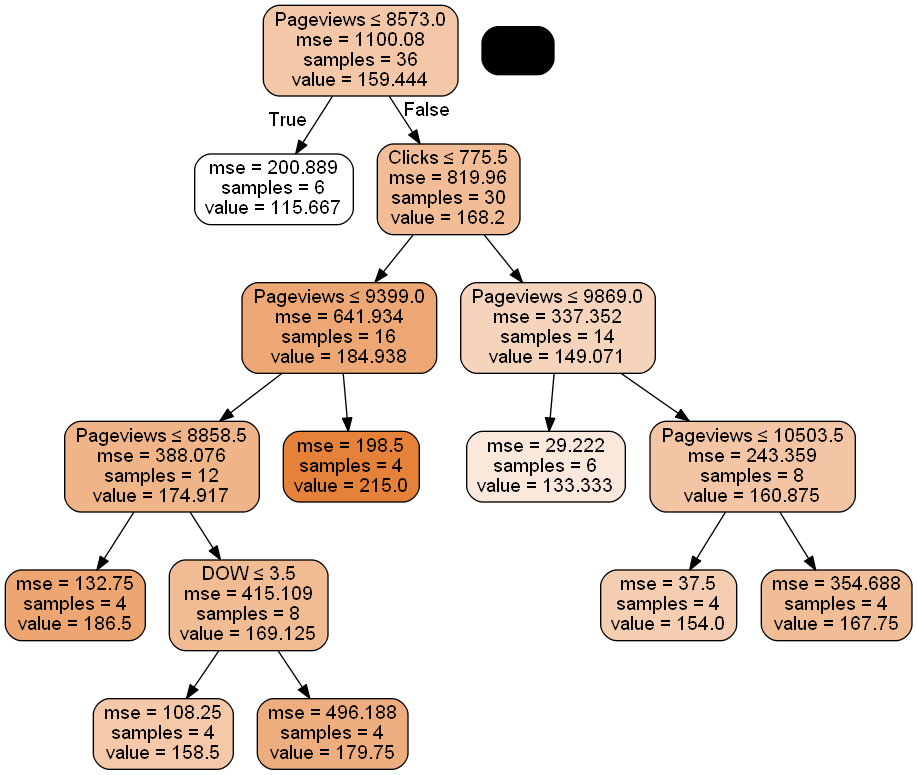

In [30]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data, 
                feature_names=X_train_refined.columns,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Model 03: `XGBoost`

In [31]:
import xgboost as xgb

In [32]:
DM_train = xgb.DMatrix(data=X_train_refined,label=y_train)
DM_test = xgb.DMatrix(data=X_test_refined,label=y_test)

In [33]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}

In [34]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}

In [35]:
xg_reg = xgb.train(params = parameters, dtrain=DM_train, num_boost_round=8)
y_preds = xg_reg.predict(DM_test)

[22:18:42] WARNING: d:\bld\xgboost-split_1643227225381\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:42] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:576: 
Parameters: { "gamma", "max_depth", "n_estimators", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [36]:
calculate_metrics(y_test, y_preds)

RMSE Score: 20.29519355508288
R2_Squared: 0.32070901537324736
MAE Score: 18.094000244140624


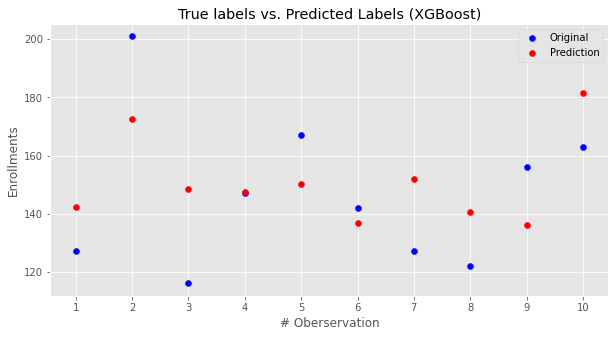

In [37]:
plot_preds(y_test, y_preds, 'XGBoost')

> I used a `gblinear` booster for XGBoost and XGBoost currently does support feature importances linear models.

## Model 04: H2O.ai's AutoML

In [38]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,11 hours 8 mins
H2O_cluster_timezone:,America/Caracas
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_sthor_1929wq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.656 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


> To use h2o.ai's utilities on the dataset, the library requires the data to be in **H2OFrame** format. 

In [39]:
X_train['Enrollments'] = y_train
X_test['Enrollments'] = y_test

In [40]:
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [41]:
features = X_train.columns.values.tolist()
target = "Enrollments"

In [42]:
# Construct the AutoML pipeline
auto_h2o = H2OAutoML()
# Train 
auto_h2o.train(x=features,
               y=target,
               training_frame=X_train_h2o)

AutoML progress: |█
22:19:40.472: AutoML: XGBoost is not available; skipping it.
22:19:40.478: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
22:19:40.478: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
22:19:41.505: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 36.0.

██████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_3_AutoML_2_20220216_221940_model_18


Status of Neuron Layers: predicting Enrollments, regression, gaussian distribution, Quadratic loss, 981 weights/biases, 16.7 KB, 360,360 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,5,Input,20,,,,,,,,,
1,,2,20,RectifierDropout,10,0,0,0.00107892,0.000665068,0,0.0377325,0.444314,0.272544,0.283323
2,,3,20,RectifierDropout,10,0,0,0.00159281,0.000854922,0,-0.105346,0.324703,0.863045,0.203955
3,,4,20,RectifierDropout,10,0,0,0.00728012,0.0129401,0,-0.127681,0.427606,0.748669,0.248562
4,,5,1,Linear,,0,0,0.000814401,0.000329784,0,-0.037075,0.352971,0.112062,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 68.51000551450983
RMSE: 8.277077111789513
MAE: 7.054964626858424
RMSLE: 0.05657427119280378
Mean Residual Deviance: 68.51000551450983

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 365.78492523369846
RMSE: 19.125504574617068
MAE: 16.498268620429467
RMSLE: 0.11961453283652955
Mean Residual Deviance: 365.78492523369846

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,16.427750,2.457145,18.966446,15.687699,16.490303,12.720312,18.273987
1,mean_residual_deviance,359.974850,132.337200,569.137630,354.673370,297.229700,210.735320,368.098200
2,mse,359.974850,132.337200,569.137630,354.673370,297.229700,210.735320,368.098200
3,r2,0.576492,0.156708,0.716986,0.533625,0.323348,0.638773,0.669728
4,residual_deviance,359.974850,132.337200,569.137630,354.673370,297.229700,210.735320,368.098200
5,rmse,18.726469,3.408488,23.856606,18.832773,17.240350,14.516726,19.185886
6,rmsle,0.116811,0.024147,0.145535,0.135175,0.099875,0.087095,0.116375



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-02-16 23:15:34,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-02-16 23:15:34,7 min 47.264 sec,120000 obs/sec,10.0,1,360.0,24.590065,604.671296,20.901119,0.450339
2,,2022-02-16 23:15:36,7 min 49.007 sec,206391 obs/sec,10010.0,1001,360360.0,8.277077,68.510006,7.054965,0.937723



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,row_id,1.000000,1.000000,0.261250
1,Pageviews,0.937824,0.937824,0.245006
2,Clicks,0.765883,0.765883,0.200087
3,DOW,0.705140,0.705140,0.184218
4,Experiment,0.418906,0.418906,0.109439


In [43]:
# Overview of how the models performed
auto_h2o.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DeepLearning_grid_3_AutoML_2_20220216_221940_model_18,365.785,19.1255,365.785,16.4983,0.119615
DeepLearning_grid_2_AutoML_2_20220216_221940_model_36,394.038,19.8504,394.038,16.8561,0.121735
StackedEnsemble_BestOfFamily_7_AutoML_2_20220216_221940,409.902,20.246,409.902,16.2832,0.12661
DeepLearning_grid_1_AutoML_2_20220216_221940_model_108,413.071,20.3242,413.071,17.5252,0.132557
GBM_grid_1_AutoML_2_20220216_221940_model_496,431.236,20.7662,431.236,17.3388,0.127497
DeepLearning_grid_1_AutoML_2_20220216_221940_model_425,437.802,20.9237,437.802,17.2059,0.12722
StackedEnsemble_BestOfFamily_4_AutoML_2_20220216_221940,439.314,20.9598,439.314,17.3651,0.129793
DeepLearning_grid_1_AutoML_2_20220216_221940_model_285,440.6,20.9905,440.6,16.268,0.131085
StackedEnsemble_BestOfFamily_3_AutoML_2_20220216_221940,442.881,21.0447,442.881,17.417,0.133065
DeepLearning_grid_1_AutoML_2_20220216_221940_model_366,451.075,21.2385,451.075,17.9485,0.138513


In [44]:
# Extract the best model from the leaderboard
auto_h2o = auto_h2o.leader

In [45]:
X_test_temp = X_test.copy()
del X_test_temp['Enrollments']

In [46]:
# Employing the model to make inference
X_test_h2o_copy = h2o.H2OFrame(X_test_temp)
y_preds = auto_h2o.predict(X_test_h2o_copy)

# Convert the predictions to a native list
y_preds = h2o.as_list(y_preds["predict"])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [47]:
calculate_metrics(y_test, y_preds)

RMSE Score: 24.791272260901398
R2_Squared: -0.01360112856082063
MAE Score: 23.315018863622157


> **XGBoost Still Wins!**